In [1]:
# import everything

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# load the data

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# [60000, 28, 28], [10000, 28, 28], [60000, ], [10000, ]

In [ ]:
# define model

dim = [(28 * 28,), 512, 512, 10]
#input, first layer, second layer,output

def makeModel(dim):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=dim[0]))
    model.add(keras.layers.Dense(dim[1], activation="relu"))
    model.add(keras.layers.Dense(dim[2], activation="relu"))
    model.add(keras.layers.Dense(dim[3], activation="softmax"))
    return model

model = makeModel(dim)
print(model.output_shape) # should be 10

In [ ]:
# compiling

optimizerMethod = "adam"
lossFunction = "categorical_crossentropy"
metricsLst = ["accuracy"]
model.compile(optimizer=optimizerMethod, loss=lossFunction, metrics=metricsLst)

In [ ]:
# clean and organize the data
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = x_train.reshape(60000, 28 * 28)/255.0
x_test = x_test.reshape(10000, 28 * 28)/255.0

nClass = 10
y_train = keras.utils.to_categorical(y_train, nClass)
y_test = keras.utils.to_categorical(y_test, nClass)

In [ ]:
# train the model

model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=2, validation_data=(x_test, y_test))

In [ ]:
# evaluate

results = model.evaluate(x_test, y_test, verbose=2)
print("Loss: ", results[0])
print("Accuracy: ", results[1])

In [ ]:
# save the model
# model = tf.keras.applications.mobilenet.MobileNet(input_shape=(1, 28 * 28, 3), weights=None)
# model.save('handwritten_model')

Trying to use TFLite

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

In [ ]:
# import pathlib

# tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
# tflite_models_dir.mkdir(exist_ok=True, parents=True)

# # Save the unquantized/float model:
# tflite_model_file = tflite_models_dir/"mnist_model.tflite"
# tflite_model_file.write_bytes(tflite_model)
# # Save the quantized model:
# tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
# tflite_model_quant_file.write_bytes(tflite_model_quant)

In [8]:
import pathlib

# tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
# tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
# tflite_model_file = tflite_models_dir/"mnist_model.tflite"
# tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = pathlib.Path.cwd()/"mnist_model_quant.tflite"
# with open('tflite_model_quant_file', 'wb') as f:
#   f.write(tflite_model_quant)
# tflite_model_quant_file.write_bytes(tflite_model_quant)

In [3]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global x_test

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    
    # reshape test_image
    test_image = tf.reshape(test_image, [1, 784])
    
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [4]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global y_test

  predictions = run_tflite_model(tflite_file, [test_image_index])

  tmp = tf.reshape(x_test[test_image_index], [28, 28])
  plt.imshow(tmp)
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(y_test[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

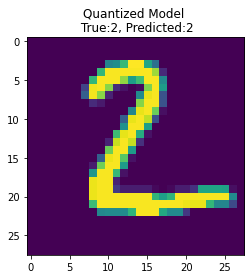

In [10]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

In [5]:
def getClass(lst):
    return np.argmax(lst)

In [6]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global x_test
  global y_test

  test_image_indices = range(x_test.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)
  tmp = [getClass(e) for e in y_test]

  accuracy = (np.sum(tmp == predictions) * 100) / len(x_test)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(x_test)))

In [9]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 8.4900% (Number of test samples=10000)


In [7]:
evaluate_model("mnist_model_quant.tflite", model_type="Quantized")

Quantized model accuracy is 8.4900% (Number of test samples=10000)
